# Tools for Visualization 

This tutorial shows tools from PlantCV that can be used to visualize pixel color and size, which help users better estimate inputs for thresholding and fill functions to remove background without degrading plant material in binary masks.

# Section 1: Importing libraries and image

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [2]:
# Import libraries
from plantcv import plantcv as pcv

## Input variables
The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [6]:
class options:
    def __init__(self):
        self.image = "./img/side_view_img.png"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "visualization_results.txt"
        self.outdir = "."

In [7]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 2
pcv.params.text_thickness = 2
pcv.params.line_thickness = 10

## Read the input image

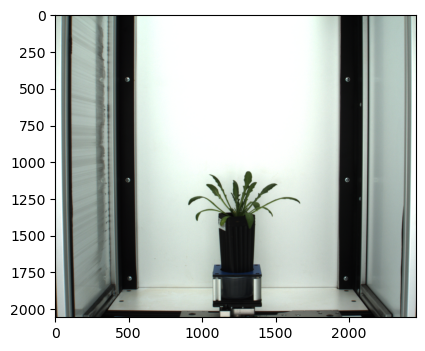

In [8]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Creating masks using visualization methods

Creating masks can be difficult without a good sense of the best colorspace, approximate threshold that distinguishes plant from background, and the size of salt & pepper noise. Recent updates to PlantCV have introduces functions that allow the user to visualize aspects of the image prior to thresholding.

See Tools for Thresholding Plant Data for more functions that can be used to create binary masks.

## Visualize colorspaces
The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

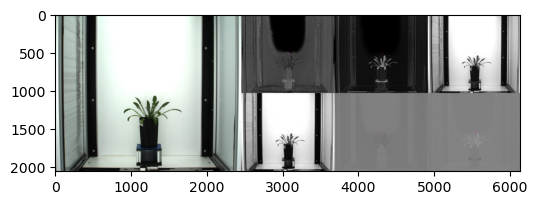

In [9]:
# Inputs:
#   rgb_img = colored image
#   original_image = 'True' (default)
colorspace = pcv.visualize.colorspaces(rgb_img = img)

## Convert the color image to grayscale¶
Select a colorspace that looks promising for isolating plant from background
In this case, channel 'a' looks good, since the plant is darker than both the backdrop and the pot. Channels like 'l' would make isolating plant material much more difficult, as the plant and pot are similar shades. The function pcv.rgb2gray_lab can be used to select any of the bottom three channels, and pcv.rgb2gray_hsv can be used to select the top three channels.

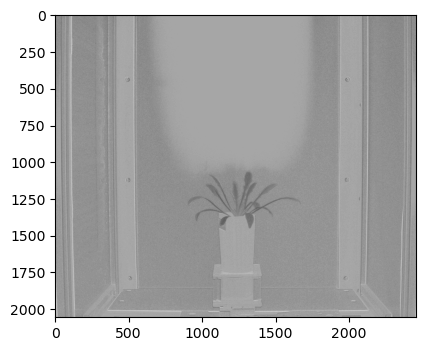

In [10]:
# Inputs:
#   rgb_img = color image
#   channel = 'l', 'a', or 'b'
a = pcv.rgb2gray_lab(rgb_img = img, channel = 'a')

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 115-130 are from the lighter background pixels. The smaller peaks that represent plant material cannot be distinguished because there are so few total plant pixels, but we can use the lower bound of the background peaks to estimate a good thresholding point, somewhere between 110-115.

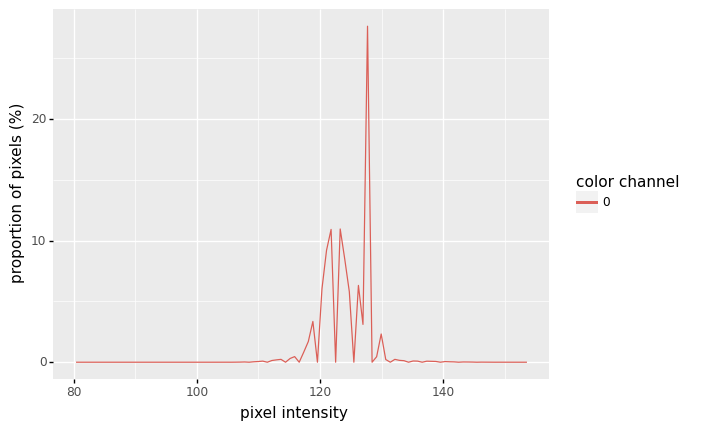

In [11]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img = a)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 110-115 will segment the plant and background peaks. Because the plant has darker pixels in this image, use object_type="dark" to do an inverse threshold.

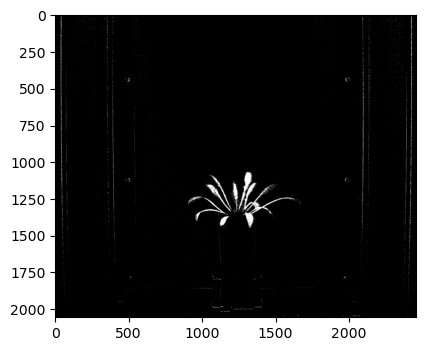

In [12]:
# Inputs:
#   gray_img    = gray image
#   threshold   = value 0-255, all values above threshold will be made white or black, and all values under will be 
#                 the opposite value
#   max_value   = maximum value for the binary mask
#   object_type = shade of the plant material in reference to the rest of the image
a_thresh_test1 = pcv.threshold.binary(gray_img = a, threshold = 115, max_value = 255, object_type = 'dark')

## Test another threshold value

This threshold seems to exclude most of the background, but also causes use to lose some plant material. We can now try a slightly higher threshold in order to reduce plant material loss.

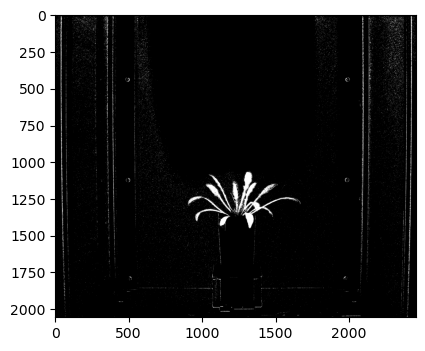

In [13]:
# Inputs:
#   gray_img    = gray image
#   threshold   = value 0-255, all values above threshold will be made white or black, and all values under will be 
#                 the opposite value
#   max_value   = maximum value for the binary mask
#   object_type = shade of the plant material in reference to the rest of the image
a_thresh_test2 = pcv.threshold.binary(gray_img = a, threshold = 117, max_value = 255, object_type = 'dark')

## Visualize 'salt' background noise

Now we have a binary mask that captures the plant material. However, there is still some grainy 'salt' noise in the background which needs to be filled in. During this step, we need to be cautious to not fill in any plant material. Here, we can visualize the sizes of objects within the image, in order to find an input size for the fill function that will remove background noise within removing plant material.

NOTE: This function is not included in the most recent update of PlantCV. Will become available in next PlantCV update.

In [14]:
# Inputs:
#   mask = binary mask
#   title = plot title (default = 'None')
# hist_sizes = pcv.visualize.obj_size_ecdf(mask = a_thresh_test2)

## Remove background noise

From the previous input, we can estimate that a good size input for the fill function would be around 50, which will remove background noise, but avoid removing the larger sections of the binary mask that represent plant material.

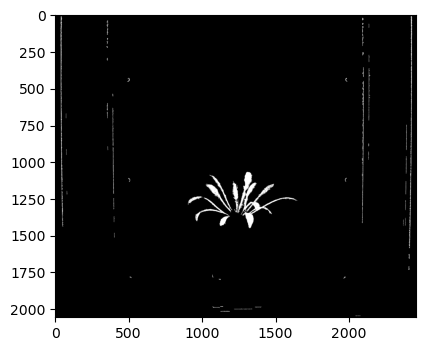

In [16]:
a_fill = pcv.fill(bin_img = a_thresh_test2, size = 50)

And now we have a binary mask that can be used to find objects and perform various analyses offered by PlantCV. These visualization methods are also demonstrated in various workflows, such as the morphology workflows.